# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Dense, Flatten, Bidirectional, LSTM, Conv2D, MaxPooling2D
from tensorflow.keras import Sequential
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
!pip install pydub
from IPython.display import clear_output
from scipy.io.wavfile import write, read
from IPython.display import Audio
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os

clear_output(wait=False)

# Importing Dataset

In [2]:
ds, info = tfds.load('crema_d', with_info=True, as_supervised=True)
clear_output(wait=False)
print(ds)

{Split('train'): <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('validation'): <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('test'): <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [3]:
tfds.as_dataframe(ds['train'].take(3), info)

audio  label
0  [-90, -97, -111, -136, -121, -168, -170, -196,...      3
1  [-212, -221, -231, -215, -230, -197, -209, -19...      1
2  [382, 363, 379, 377, 391, 379, 361, 338, 381, ...      2

In [4]:
print(tfds.as_dataframe(ds['train'].take(3), info))

                                               audio  label
0  [-90, -97, -111, -136, -121, -168, -170, -196,...      3
1  [-212, -221, -231, -215, -230, -197, -209, -19...      1
2  [382, 363, 379, 377, 391, 379, 361, 338, 381, ...      2


In [5]:
dataframes = {'train': tfds.as_dataframe(ds['train'], info), 'test': tfds.as_dataframe(ds['test'], info), 'val': tfds.as_dataframe(ds['validation'], info)}

# Understanding the data

In [6]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

In [7]:
def create_emotions(df):
  df['emotion'] = np.nan
  df['emotion'][df['label'] == 0] = "Neutral"
  df['emotion'][df['label'] == 1] = "Happy"
  df['emotion'][df['label'] == 2] = "Sad"
  df['emotion'][df['label'] == 3] = "Anger"
  df['emotion'][df['label'] == 4] = "Fear"
  df['emotion'][df['label'] == 5] = "Disgust"

  return df

train_df = create_emotions(dataframes['train'])
test_df = create_emotions(dataframes['test'])
val_df = create_emotions(dataframes['val'])

clear_output(wait=False)

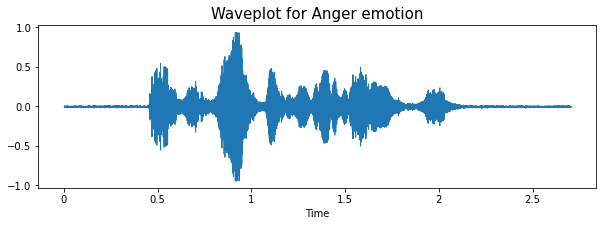

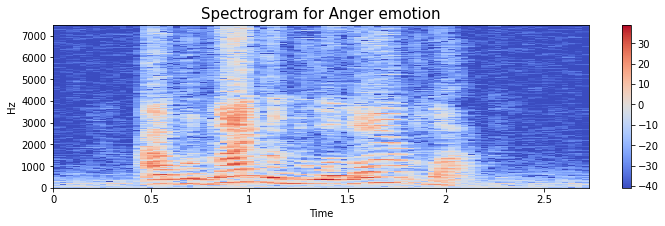

In [8]:
emotion = train_df.emotion.values[0]
data, sampling_rate = np.float_(train_df['audio'].values[0])/35000, 15000
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(data, rate=sampling_rate)

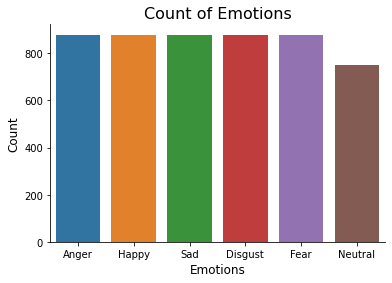

In [9]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=train_df['emotion'])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Preprocessing

In [10]:
dataframes['train'].head()

,audio,label,emotion
0,"[-90, -97, -111, -136, -121, -168, -170, -196,...",3,Anger
1,"[-212, -221, -231, -215, -230, -197, -209, -19...",1,Happy
2,"[382, 363, 379, 377, 391, 379, 361, 338, 381, ...",2,Sad
3,"[71, 33, 38, 6, 10, -22, -24, -42, -40, -69, -...",5,Disgust
4,"[-249, -234, -260, -242, -239, -238, -167, -14...",5,Disgust


In [11]:
def create_features_and_targets(df):
  mfcc_data = {
        "labels": [],
        "mfcc": []
    }

  for i in range(len(df)):
    mfcc_data['labels'].append(df.iloc[i,1])
    signal, sample_rate = df.iloc[i,0]/22050, 22050
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T
    mfcc_data['mfcc'].append(mfcc)
    
    if i%500==0:
        print(i)

  features = tf.keras.preprocessing.sequence.pad_sequences(mfcc_data['mfcc'])


  # le = LabelEncoder()
  # targets = to_categorical(le.fit_transform(df.emotion.values))
  targets = np.array(mfcc_data['labels'])
  
  print(features.shape, targets.shape)

  return features, targets

In [12]:
X_train, y_train = create_features_and_targets(dataframes['train'])
X_test, y_test = create_features_and_targets(dataframes['test'])
X_val, y_val = create_features_and_targets(dataframes['val'])
clear_output(wait=False)

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(5144, 157, 13) (5144,)
(1556, 138, 13) (1556,)
(738, 142, 13) (738,)


# First Model

In [14]:
def build_model(input_shape):
    model = Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(6, activation='softmax'))

    return model

In [15]:
# create network
input_shape = (None, 13)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         72704     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 126,662
Trainable params: 126,662
Non-trainable params: 0
_________________________________________________________________


In [16]:
#Fit Model
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[rlrp])

Epoch 1/50
161/161 [==============================] - 12s 23ms/step - loss: 1.5812 - accuracy: 0.3311 - val_loss: 1.4657 - val_accuracy: 0.3848 - lr: 0.0010
Epoch 2/50
161/161 [==============================] - 3s 17ms/step - loss: 1.4889 - accuracy: 0.3771 - val_loss: 1.3941 - val_accuracy: 0.4295 - lr: 0.0010
Epoch 3/50
161/161 [==============================] - 3s 17ms/step - loss: 1.4586 - accuracy: 0.4067 - val_loss: 1.4016 - val_accuracy: 0.4553 - lr: 0.0010
Epoch 4/50
161/161 [==============================] - 3s 18ms/step - loss: 1.4116 - accuracy: 0.4308 - val_loss: 1.3568 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 5/50
161/161 [==============================] - 3s 17ms/step - loss: 1.3811 - accuracy: 0.4471 - val_loss: 1.2846 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 6/50
161/161 [==============================] - 3s 17ms/step - loss: 1.3261 - accuracy: 0.4819 - val_loss: 1.2927 - val_accuracy: 0.4932 - lr: 0.0010
Epoch 7/50
161/161 [==============================] - 3s 18ms/s

49/49 [==============================] - 1s 14ms/step - loss: 2.2559 - accuracy: 0.5758
Accuracy of our model on test data :  57.58354663848877 %


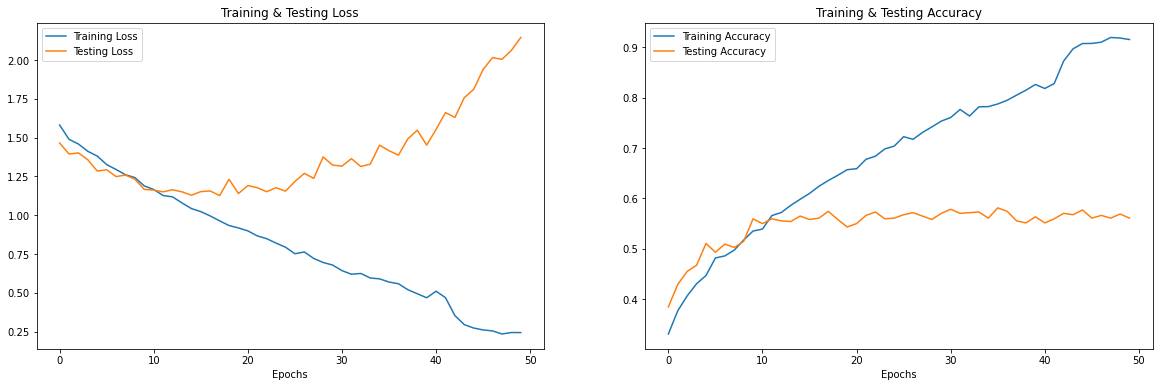

In [18]:
# Calculate pre-training accuracy 
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


# Preprocessing n°2

In [19]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
#data, sampling_rate = np.float_(train_df['audio'].values[0])/22050, 22050

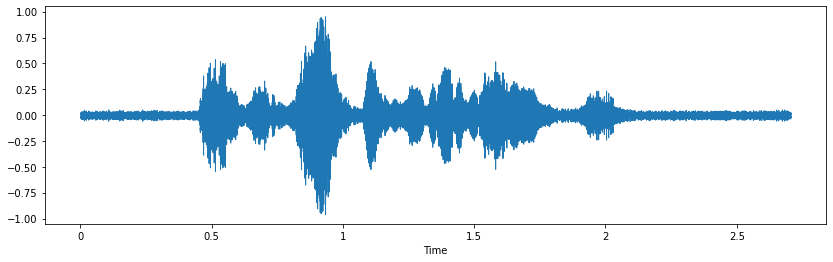

In [20]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

In [21]:
def extract_features(data):
    sample_rate = 22050

    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(seq):

    data, sample_rate = seq/22050, 22050
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [22]:
def split(df):
    X = []
    for i in range(len(df)):
        seq = df.iloc[i,0]
        features = get_features(seq)
        X.append(features)

        if i%500 == 0:
            print(i, " sequences proceeded")
    
    y = df.iloc[:,1].values
    # y = np.vstack((y, y, y))
    X = np.array(X)

    return X, y

In [23]:
X_train, y_train = split(dataframes['train'])
X_test, y_test = split(dataframes['test'])
X_val, y_val = split(dataframes['val'])
clear_output(wait=False)

In [30]:
#function to avoid to run again. The computation of split is very very long.
def reshape(X, y):
  y = y.reshape(-1,1)
  y = np.vstack((y, y, y))
  X = np.vstack((X[:,0,:], X[:,1,:], X[:,2,:]))
  return X, y

In [32]:
X_train_reshaped, y_train_reshaped = reshape(X_train, y_train)
X_test_reshaped, y_test_reshaped = reshape(X_test, y_test)
X_val_reshaped, y_val_reshaped = reshape(X_val, y_val)
print(X_train_reshaped.shape, y_train_reshaped.shape)
print(X_test_reshaped.shape, y_test_reshaped.shape)
print(X_val_reshaped.shape, y_val_reshaped.shape)

(15432, 162) (15432, 1)
(4668, 162) (4668, 1)
(2214, 162) (2214, 1)


In [43]:
scaler = StandardScaler()
X_train_reshaped = scaler.fit_transform(X_train_reshaped)
X_test_reshaped = scaler.transform(X_test_reshaped)
X_val_reshaped = scaler.transform(X_val_reshaped)

In [44]:
X_train_expanded= np.expand_dims(X_train_reshaped, axis=2)
X_test_expanded = np.expand_dims(X_test_reshaped, axis=2)
X_val_expanded = np.expand_dims(X_val_reshaped, axis=2)

In [45]:
print(X_train_expanded.shape, y_train_reshaped.shape)
print(X_test_expanded.shape, y_test_reshaped.shape)
print(X_val_expanded.shape, y_val_reshaped.shape)

(15432, 162, 1) (15432, 1)
(4668, 162, 1) (4668, 1)
(2214, 162, 1) (2214, 1)


# Second Model

In [46]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train_expanded.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 21, 128)         

In [47]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(X_train_expanded, y_train_reshaped, batch_size=64, epochs=50, validation_data=(X_val_expanded, y_val_reshaped), callbacks=[rlrp])

Epoch 1/50
242/242 [==============================] - 3s 10ms/step - loss: 1.6264 - accuracy: 0.3026 - val_loss: 1.5024 - val_accuracy: 0.3817 - lr: 0.0010
Epoch 2/50
242/242 [==============================] - 2s 9ms/step - loss: 1.5427 - accuracy: 0.3475 - val_loss: 1.5027 - val_accuracy: 0.3541 - lr: 0.0010
Epoch 3/50
242/242 [==============================] - 3s 11ms/step - loss: 1.5230 - accuracy: 0.3618 - val_loss: 1.4453 - val_accuracy: 0.4038 - lr: 0.0010
Epoch 4/50
242/242 [==============================] - 2s 10ms/step - loss: 1.4870 - accuracy: 0.3766 - val_loss: 1.4244 - val_accuracy: 0.4088 - lr: 0.0010
Epoch 5/50
242/242 [==============================] - 2s 9ms/step - loss: 1.4686 - accuracy: 0.3847 - val_loss: 1.4151 - val_accuracy: 0.4079 - lr: 0.0010
Epoch 6/50
242/242 [==============================] - 2s 9ms/step - loss: 1.4383 - accuracy: 0.4017 - val_loss: 1.3788 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 7/50
242/242 [==============================] - 2s 9ms/step -

146/146 [==============================] - 1s 4ms/step - loss: 2.2200 - accuracy: 0.4070
Accuracy of our model on test data :  40.70265591144562 %


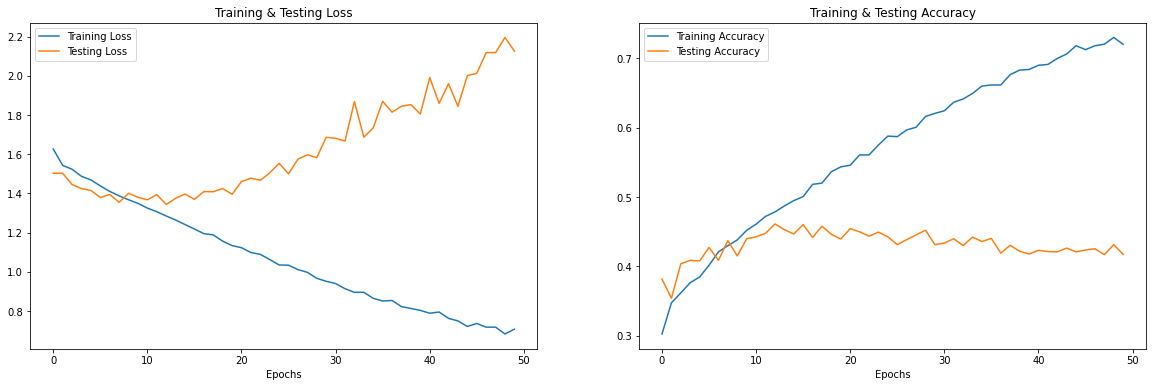

In [48]:
print("Accuracy of our model on test data : " , model.evaluate(X_test_expanded,y_test_reshaped)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# # predicting on test data.
# pred_test = model.predict(x_test)
# y_pred = encoder.inverse_transform(pred_test)

# y_test = encoder.inverse_transform(y_test)

In [ ]:
# df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
# df['Predicted Labels'] = y_pred.flatten()
# df['Actual Labels'] = y_test.flatten()

# df.head(10)